# Virtual datacube: process multiple collections in one SentinelHub request
## Outline
1. SentinelHub configuration
2. Define AOI
3. Prepare collections
   1. BYOC collections
   2. FAIRiCube collections
3. Request collections (data fusion)

## Resources
### SentinelHub Documentation (higher level)
- What is evalscript: <https://docs.sentinel-hub.com/api/latest/evalscript/v3/>
- Evalscript is used for Process API <https://docs.sentinel-hub.com/api/latest/api/process/>
- and for Batch process API <https://docs.sentinel-hub.com/api/latest/api/batch/>

### SentinelHub Python documentation
- Process API <https://sentinelhub-py.readthedocs.io/en/latest/examples/process_request.html>
- Data fusion <https://sentinelhub-py.readthedocs.io/en/latest/examples/data_collections.html#Data-fusion>

- Collection of custom evalscripts <https://custom-scripts.sentinel-hub.com/>

## 1. SentinelHub configuration

In [1]:
# Configure plots for inline use in Jupyter Notebook
%matplotlib inline

import datetime as dt

# Utilities
import boto3
import dateutil
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import os
import rasterio
# Various utilities
import json
import xarray as xr
import shapely.geometry
import IPython.display
import zarr

# Sentinel Hub
from sentinelhub import (
    CRS,
    BBox,
    ByocCollection,
    ByocCollectionAdditionalData,
    ByocCollectionBand,
    ByocTile,
    DataCollection,
    DownloadFailedException,
    MimeType,
    SentinelHubBYOC,
    SentinelHubRequest,
    SHConfig,
    bbox_to_dimensions,
    os_utils,
)

# The following is not a package. It is a file utils.py which should be in the same folder as this notebook.
from f03_datafusion_utils import *

config = SHConfig()
config.instance_id = os.environ.get("SH_INSTANCE_ID")
config.sh_client_id = os.environ.get("SH_CLIENT_ID")
config.sh_client_secret = os.environ.get("SH_CLIENT_SECRET")
config.aws_access_key_id = os.environ.get("username")
config.aws_secret_access_key = os.environ.get("password")

## 2. Define AOI and visualize it

In [2]:
x1 = 6  # degree
y1 = 49  # degree
x2 = 6.9 # degree
y2 = 49.9  # degree

bbox_lux = x1, y1, x2, y2

resolution = 60
lux_bbox = BBox(bbox=bbox_lux, crs=CRS.WGS84)
lux_size = bbox_to_dimensions(lux_bbox, resolution=resolution)
print(f"Image shape at {resolution} m resolution: {lux_size} pixels")

IPython.display.GeoJSON(shapely.geometry.box(*bbox_lux).__geo_interface__)

Image shape at 60 m resolution: (1143, 1631) pixels


<IPython.display.GeoJSON object>

## 3. Prepare collections
### 3.1 BYOC collection
- Check which BYOC collections are registered
- Copy collectio_id

In [3]:
list_byoc_collections(list_tiles=False)

Collection name: urban_audit_2021_city
Collection id:  20774d38-7b2e-43e9-b574-66fa2954da1c
-------------------
Collection name: UrbanAtlas2018_10m_raster_demo
Collection id:  55c49191-4afa-4384-956e-e9b746f259f3
-------------------
Collection name: nuts3_2021
Collection id:  81a17892-38ff-470a-ae46-b64313acd7b3
-------------------
Collection name: UrbanAtlas2012_10m_raster
Collection id:  9b562d1d-7865-4a86-b7b5-1a8d75b44f1d
-------------------
Collection name: UrbanAtlas2012_10m_raster
Collection id:  9f55dbb0-7d68-4c7b-8755-9d62d6e00981
-------------------
Collection name: urban_audit_2021_fua
Collection id:  b17f90da-1308-439e-b675-6e3a87f883de
-------------------
Collection name: UrbanAtlas2012_10m_raster
Collection id:  c3911665-7887-4a64-a0d5-c918b0472a39
-------------------
Collection name: nuts3_2021
Collection id:  ed7c0bf4-e85f-498c-ad18-f3e83fb89a6f
-------------------


In [4]:
collection_id_UA = "55c49191-4afa-4384-956e-e9b746f259f3"
collection_name_UA = "UrbanAtlas2018_10m_raster"
data_collection_UA = DataCollection.define_byoc(collection_id_UA, name=collection_name_UA)
data_collection_UA

<DataCollection.UrbanAtlas2018_10m_raster: DataCollectionDefinition(
  api_id: byoc-55c49191-4afa-4384-956e-e9b746f259f3
  catalog_id: byoc-55c49191-4afa-4384-956e-e9b746f259f3
  wfs_id: byoc-55c49191-4afa-4384-956e-e9b746f259f3
  collection_type: BYOC
  collection_id: 55c49191-4afa-4384-956e-e9b746f259f3
  is_timeless: False
  has_cloud_coverage: False
)>

### 3.2 Collections from FAIRiCube
Example with following collections:
1. FAIRiCube collection:
   - Collection Name: Population_density
   - collectionId: "b468089b-2627-4787-b984-89c10434f6c6"
   - FAIRiCube Catalog: <https://catalog.fairicube.eu/population_density/>
2. FAIRiCube Collection:
   - Collection name: CORINE Land Cover Accounting Layers
   - CollectionId: 4c5441a6-6040-4dc4-a392-c1317bbd1031
   - End Point: https://creodias.sentinel-hub.com
   - FAIRiCube Catalog: <https://catalog.fairicube.eu/population_density/>
In the second example we have to specify the `service_url` parameter, that is, the endpoint. If it is not specified, the function uses the endpoint given in `config`


**Problem with CLC_ACC collection: data fusion of collections from different end points does not seem to work!!**

In [5]:
# copy CollectionId from FAIRiCube catalog https://catalog.fairicube.eu/
collection_id_popdens = "b468089b-2627-4787-b984-89c10434f6c6"
collection_name_popdens = "Population_density"
# define collection
data_collection_popdens = DataCollection.define_byoc(collection_id_popdens, name=collection_name_popdens)
data_collection_popdens

<DataCollection.Population_density: DataCollectionDefinition(
  api_id: byoc-b468089b-2627-4787-b984-89c10434f6c6
  catalog_id: byoc-b468089b-2627-4787-b984-89c10434f6c6
  wfs_id: byoc-b468089b-2627-4787-b984-89c10434f6c6
  collection_type: BYOC
  collection_id: b468089b-2627-4787-b984-89c10434f6c6
  is_timeless: False
  has_cloud_coverage: False
)>

In [6]:
# copy CollectionId from FAIRiCube catalog https://catalog.fairicube.eu/
collection_id_clc_acc = "4c5441a6-6040-4dc4-a392-c1317bbd1031"
collection_name_clc_acc="CLC_ACC"
end_point = "https://creodias.sentinel-hub.com"
# define collection
data_collection_clc_acc = DataCollection.define_byoc(collection_id_clc_acc, name=collection_name_clc_acc, service_url = end_point)
data_collection_clc_acc

<DataCollection.CLC_ACC: DataCollectionDefinition(
  api_id: byoc-4c5441a6-6040-4dc4-a392-c1317bbd1031
  catalog_id: byoc-4c5441a6-6040-4dc4-a392-c1317bbd1031
  wfs_id: byoc-4c5441a6-6040-4dc4-a392-c1317bbd1031
  service_url: https://creodias.sentinel-hub.com
  collection_type: BYOC
  collection_id: 4c5441a6-6040-4dc4-a392-c1317bbd1031
  is_timeless: False
  has_cloud_coverage: False
)>

### 3.3 List collections
you can see all the collections defined with the functions `DataCollection.define_byoc` or `DataCollection.define` by using `DataCollection.get_available_collections()`. They are listed with the given name

In [7]:
for collection in DataCollection.get_available_collections():
    print(collection)
# get parameters: for example, get parameters of Sentinel-2-L2A
# DataCollection.SENTINEL2_L2A

DataCollection.SENTINEL2_L1C
DataCollection.SENTINEL2_L2A
DataCollection.SENTINEL1
DataCollection.SENTINEL1_IW
DataCollection.SENTINEL1_IW_ASC
DataCollection.SENTINEL1_IW_DES
DataCollection.SENTINEL1_EW
DataCollection.SENTINEL1_EW_ASC
DataCollection.SENTINEL1_EW_DES
DataCollection.SENTINEL1_EW_SH
DataCollection.SENTINEL1_EW_SH_ASC
DataCollection.SENTINEL1_EW_SH_DES
DataCollection.DEM
DataCollection.DEM_MAPZEN
DataCollection.DEM_COPERNICUS_30
DataCollection.DEM_COPERNICUS_90
DataCollection.MODIS
DataCollection.LANDSAT_MSS_L1
DataCollection.LANDSAT_TM_L1
DataCollection.LANDSAT_TM_L2
DataCollection.LANDSAT_ETM_L1
DataCollection.LANDSAT_ETM_L2
DataCollection.LANDSAT_OT_L1
DataCollection.LANDSAT_OT_L2
DataCollection.SENTINEL5P
DataCollection.SENTINEL3_OLCI
DataCollection.SENTINEL3_SLSTR
DataCollection.UrbanAtlas2018_10m_raster
DataCollection.Population_density
DataCollection.CLC_ACC


In [8]:
# simple evalscript to check if single request works
evalscript_test = """

//VERSION=3
function setup() {
  return {
    input: ["B1"],
    output: { 
        bands: 1,
        sampleType: "UINT16" // raster format will be UINT16
        }
    
  };
}

function evaluatePixel(sample) {
  return [sample.B1];
}
"""

request = SentinelHubRequest(
        evalscript=evalscript_test,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.UrbanAtlas2018_10m_raster,
                # time_interval=("2018-01-01", "2019-01-01")
                # time_interval="2018"
            )
        ],
        responses=[
            SentinelHubRequest.output_response('default', MimeType.PNG)
        ],
        bbox=lux_bbox,
        size=bbox_to_dimensions(lux_bbox, 60),
        config=config
    )

data = request.get_data()[0]

Success!


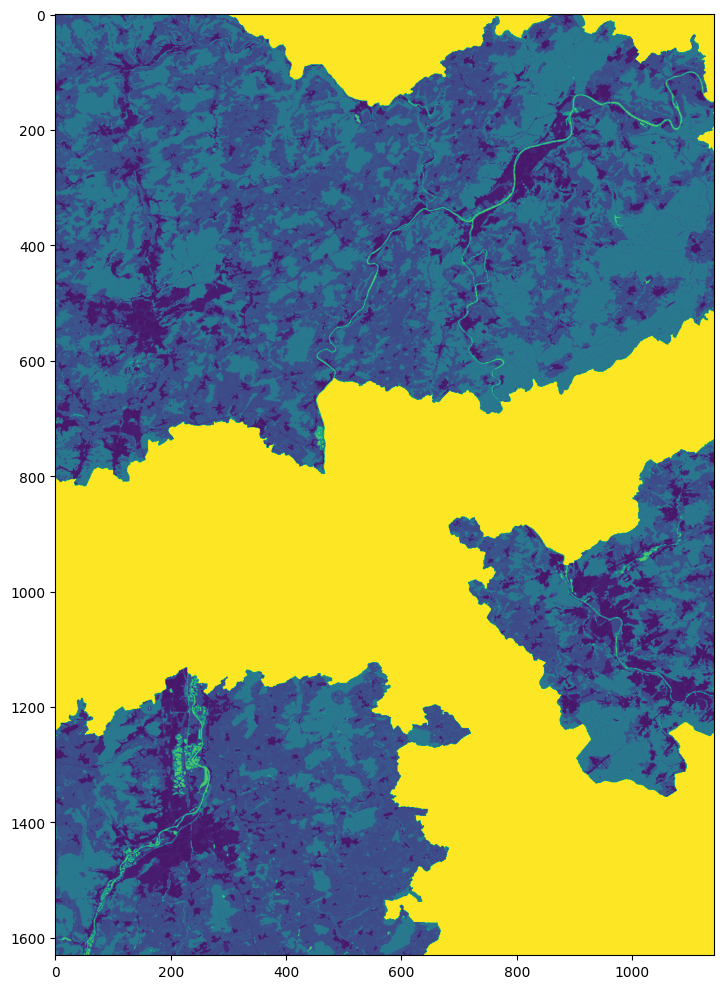

In [9]:
import numpy as np
# is there anything in the data?
if(np.std(data) == 0): 
    print("Error: data is empty :(")
else:
    print("Success!")
    # plot data
    fig, ax = plt.subplots(figsize=(10, 10))

    ax.imshow(data)
    # ax.set_title(tile_time.date().isoformat(), fontsize=10)

    plt.tight_layout()

## 5. Request collections (data fusion)
To join together data from different collections and download only the results, modify the evalscript as following:
- add SentinelHubRequest.input_data() for each requested collection, with parameter `identifier`
- in the `setup()` function, for each input collection, add the parameter `datasource`, which must be equal to `identifier`
- in `evaluatePixel`, the samples argument is now a dictionary of input datasets, where `identifier` is used as key

**Problem with CLC_ACC collection: data fusion of collections from different end points does not seem to work!!**

Image type: uint8


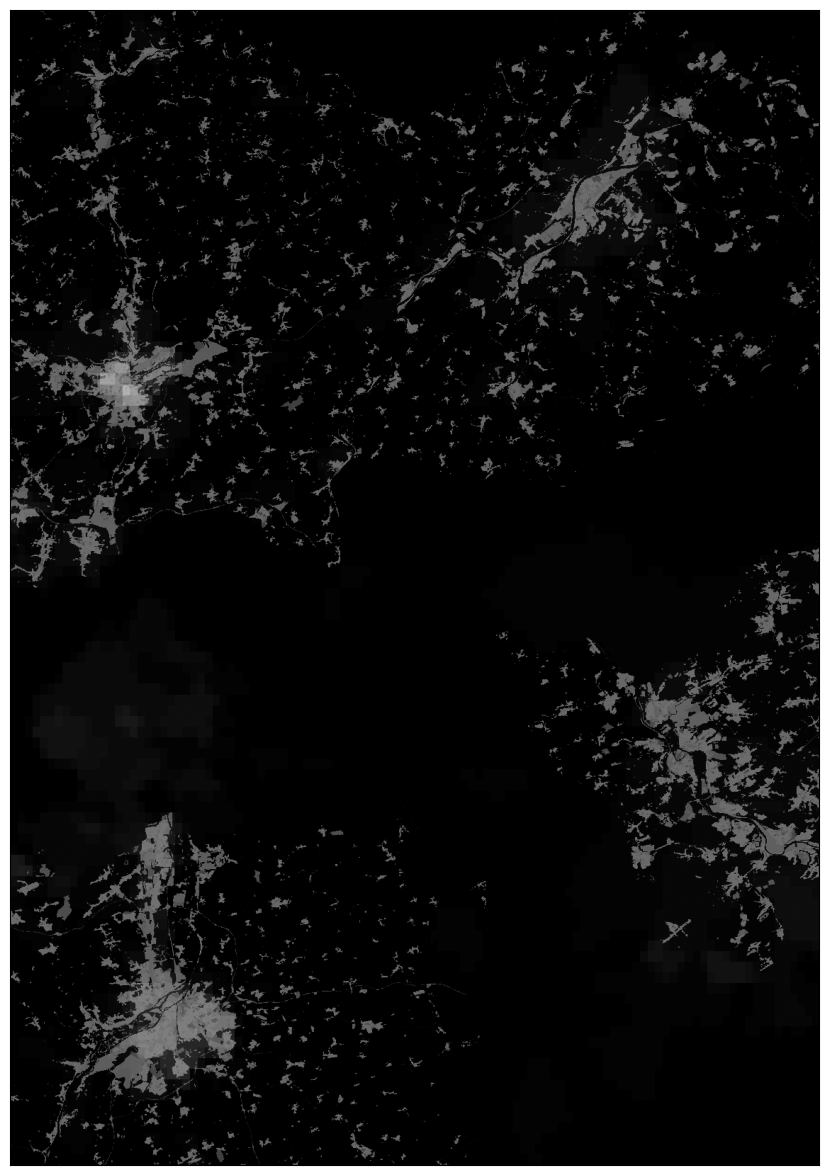

In [10]:
evalscript_true_color = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                datasource: "pop_dens",
                bands: ["populationDensity"]
            },
            {
                datasource: "UA",
                bands: ["B1"]
            }],
            output: {
                bands: 2,
                sampleType: "UINT16" // raster format will be UINT16
            }
        };
    }

    function evaluatePixel(samples, inputData, inputMetadata, customData, outputMetadata) {
      //var sample_clc_acc = samples.clc_acc[0]
      var sample_pop_dens = samples.pop_dens[0]
      var sample_ua = samples.UA[0]
      return [sample_pop_dens.populationDensity, sample_ua.B1];
    }
"""

request = SentinelHubRequest(
    evalscript=evalscript_true_color,
    input_data=[
        # SentinelHubRequest.input_data(
        #     data_collection=DataCollection.CLC_ACC,
        #     identifier="CLC_ACC",
        #     # time_interval=("2021-06-12", "2021-06-13"),
        # ),
        SentinelHubRequest.input_data(
            data_collection=DataCollection.UrbanAtlas2018_10m_raster,
            identifier="UA",
            # time_interval=("2021-06-12", "2021-06-13"),
        ),
        SentinelHubRequest.input_data(
            data_collection=DataCollection.Population_density,
            identifier="pop_dens",
            # time_interval=("2021-06-12", "2021-06-13"),
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox=lux_bbox,
    size=lux_size,
    config=config,
)
images = request.get_data()[0]
print(f"Image type: {images.dtype}")

# plot function
# factor 1/255 to scale between 0-1
# factor 3.5 to increase brightness
plot_image(images, factor=3.5 / 255, clip_range=(0, 1))

## 6. Query multi-band output

In [11]:
# check dimensions of output
print(images.shape) # (1631, 1143, 4) means 4 images of size (1631, 1143)
# get first image etc
image_1 = images[:,:,0]

(1631, 1143, 4)


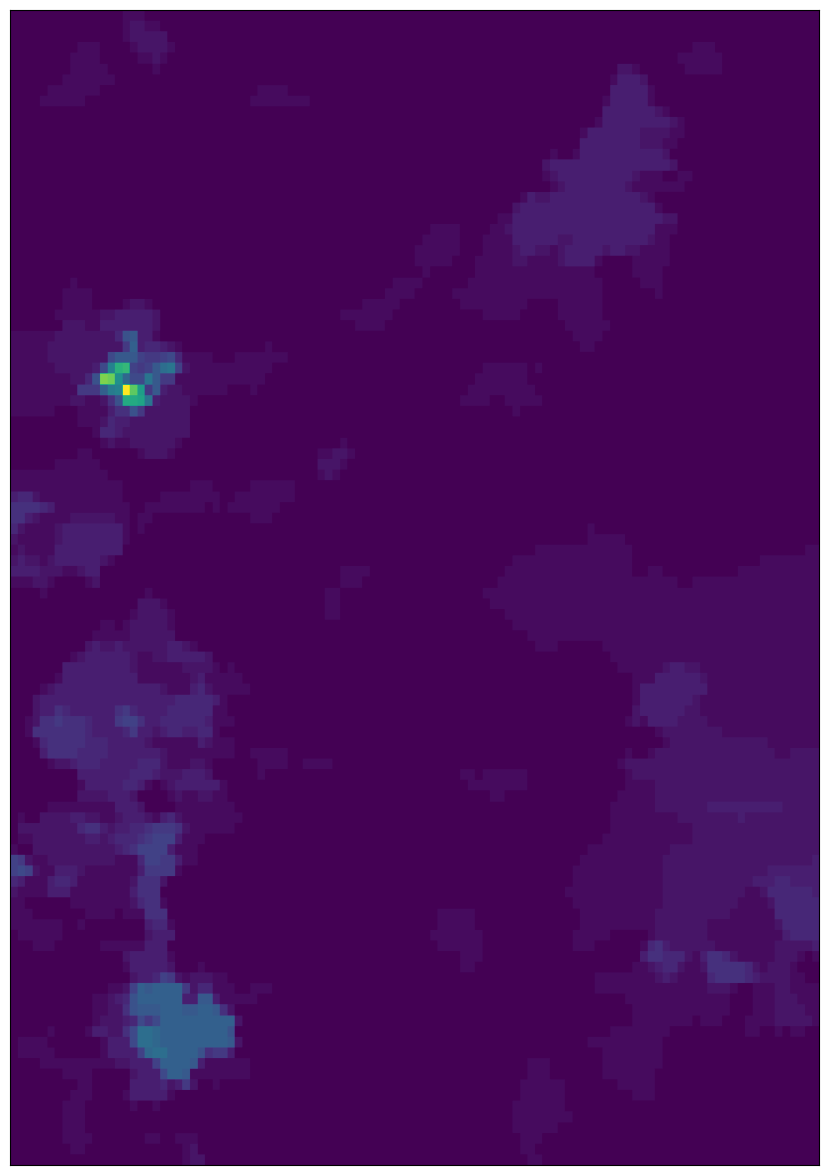

In [12]:
# plot image
plot_image(image_1, factor=3.5 / 255, clip_range=(0, 1))